In [1]:
import numpy as np
import swarms
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from random import randint, seed, uniform

try:
    plt.style.use('paper')
except:
    pass

In [2]:
Lsun = 3.828e26 # all units in SI
Msun = 1.989e30 
Tsun = 5800
pc = 3.086e16
AU = 1.496e11
Mearth = 5.97e24
Rearth = 6.4e6
Rjup = 7.e7
Mjup = 318 * Mearth
Jansky = 1.e-26

In [3]:
Mmin = 15 # Mearth (Nep)
Mmax = 13*318 # Mearth (Jup)
nvals = 600
# Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
# ignore normalization which goes into occurrence. We assume we draw a planet, just 
# want relative fractions correct
totoccurrence = 1.

Nplanets = 600
alpha = -0.86
ms = np.linspace(Mmin, Mmax, Nplanets)
pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
randv = np.random.uniform(size=nvals)
idxs = np.searchsorted(cumpdf, randv)
masses = ms[[idx for idx in idxs if idx < len(cumpdf)]]

In [4]:
GPI = pd.read_csv("../csvs/fullGPIsample.csv", index_col=0)
GPI = GPI[~GPI['Distance_distance'].isnull()]
GPI = GPI.reset_index(drop=True)
GPI['Age'] = 0
GPI.tail()

,S_Type,Distance_distance,FLUX_I,FLUX_H,Fe_H_Teff,Class,subtype,Mbol,Lum,Teff,Mass,Age
594,B9V,48.5835,NaN,4.622,10860,B,9,0.570,46.558609,10850.0,2.455,0
595,A7III/IV,67.1100,NaN,5.879,7834,A,7,2.445,8.279422,8000.0,1.595,0
596,F6V,35.3895,6.370,5.787,6255,F,6,3.860,2.249055,6400.0,1.160,0
597,K2V,21.9270,7.194,6.007,0,K,2,5.620,0.444631,4930.0,0.738,0
598,A1V,47.0754,NaN,4.949,9057,A,1,1.440,20.892961,9370.0,2.005,0


In [5]:
seed(0)

def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def draw_star(GPI):
    if isinstance(GPI, pd.Series):
        star = GPI
    else:
        idx = randint(0, GPI.shape[0]-1)
        star = GPI.loc[idx]
        
    return swarms.Star(M=star['Mass']*Msun, L=star['Lum']*Lsun, T=star['Fe_H_Teff'], d=star['Distance_distance']*pc)

In [6]:
%%time

lamb = 1.65e-6
g = 0.32

CRthermals, CRscats, CRs = np.zeros(Nplanets), np.zeros(Nplanets), np.zeros(Nplanets)
for i, m in enumerate(masses):
    star = draw_star(GPI)
    amin = 0.3*star.d/pc
    amax = 1.2*star.d/pc
    a = loguniform(amin, amax)
    if m < 20:
        m = 20
    if m > 3180:
        m = 3180
    planet = swarms.Planet(star, M=m*Mearth, a=a*AU, Q=0.5, R=None, Z='002', age=1.5e7)
    CRthermals[i] = planet.CRthermal(lamb)
    if np.isnan(CRthermals[i]):
        CRthermals[i] = 0
    CRscats[i] = planet.CRscat(g)
    CRs[i] = CRthermals[i] + CRscats[i]

/Users/dtamayo/Documents/workspace/CE-Irregular-Satellites/jupyter_examples/swarms.py:275: RuntimeWarning: divide by zero encountered in double_scalars
  return self.L/sig/self.T**4
/Users/dtamayo/Documents/workspace/CE-Irregular-Satellites/jupyter_examples/swarms.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  b = 1/(exp(h*(c/lamb)/(k_B*T)) - 1)
/Users/dtamayo/Documents/workspace/CE-Irregular-Satellites/jupyter_examples/swarms.py:224: RuntimeWarning: invalid value encountered in double_scalars
  return Ap/Astar*Bnup/Bnustar


CPU times: user 25.5 s, sys: 2.14 s, total: 27.6 s
Wall time: 27.6 s


Text(0,0.5,'Number of Planets')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


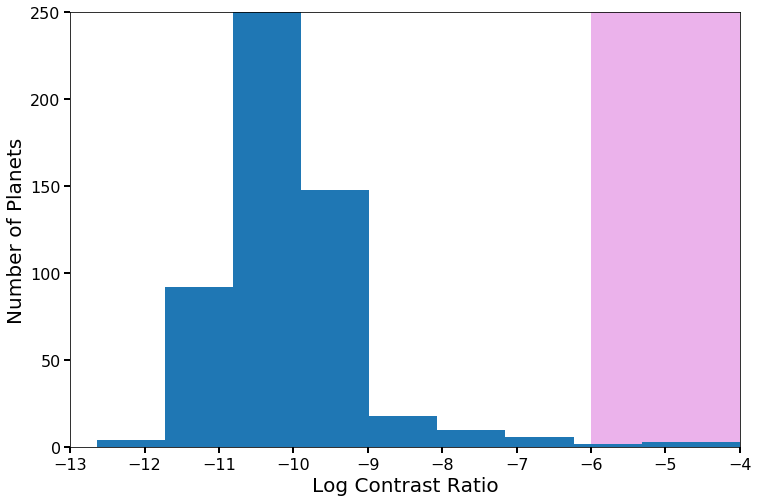

In [7]:
fig, ax = plt.subplots(figsize=(12,8))
hist, edges, patches = ax.hist(np.log10(CRs))
ax.fill_betweenx([0, 300], -6, -4, facecolor='m', alpha=0.3)
ax.set_ylim([0, 250])
ax.set_xlim([-13, -4])
ax.set_xlabel('Log Contrast Ratio')
ax.set_ylabel('Number of Planets')

Text(0,0.5,'Number of Planets')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


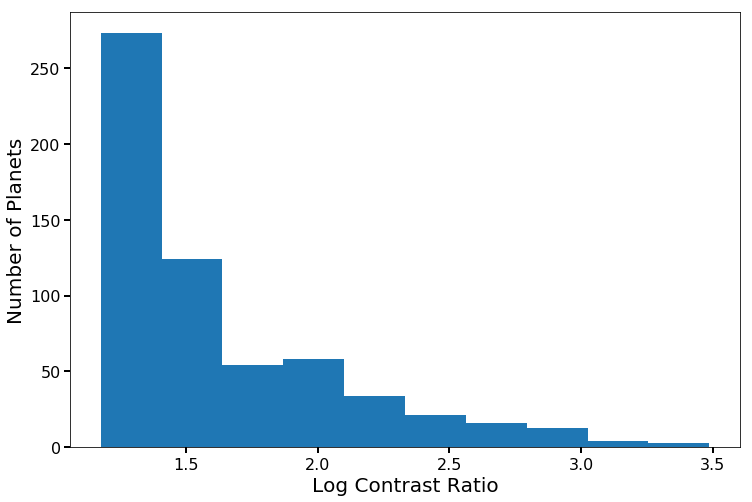

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
hist, edges, patches = ax.hist(np.log10(masses))
ax.set_xlabel('Log Contrast Ratio')
ax.set_ylabel('Number of Planets')